# Machine Translation Project (English to Spanish)

In [2]:
import pathlib
import random
import string
import tensorflow.strings as tf_strings
import tensorflow.data as tf_data
import re
from tensorflow.keras.layers import TextVectorization
import keras
import tensorflow as tf
from keras import layers
import json

### TO see the GPU in system

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8955084895122067086
xla_global_id: -1
]


##### Download And Prepare the File(Data set)
source :"http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip"

Purpose: This block of code downloads a zip file containing the parallel corpus from a specified URL and extracts it.

Parameters:

fname: The local filename to save the downloaded file as.
origin: The URL from which to download the file.
extract: A boolean value indicating whether to extract the contents of the zip file.
Example:
The zip file spa-eng.zip contains parallel text data in English and Spanish. After extraction, the contents will be available in the directory where the zip file was downloaded.

In [4]:
text_file = keras.utils.get_file(
    fname= "spa-eng.zip",
    origin="http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip",
    extract=True
    
)
# Creating the Path to the Extracted Text File

text_file=pathlib.Path(text_file).parent / "spa-eng" / "spa.txt"
print(f"Path to the text file: {text_file}")

Path to the text file: C:\Users\brije\.keras\datasets\spa-eng\spa.txt


#### Reading and Splitting the File into Lines

Purpose: Reads the entire content of the text file and splits it into individual lines.

Explanation:

open(text_file, "r"): Opens the text file in read mode.
f.read(): Reads the entire file content as a single string.
.split("\n"): Splits the string into a list of lines based on the newline character.
[:-1]: Removes the last element of the list if it is an empty string.

In [5]:
with open(text_file, "r") as f:
    lines = f.read().split("\n")[:-1]
    

#### Creating Pairs of English and Spanish Sentences
Purpose: Processes each line to create pairs of English and Spanish sentences, with special tokens added to the Spanish sentences.

In [6]:
text_pairs = []

for line in lines:
    eng, spa = line.split("\t")
    spa = "[start] " + spa + " [end]"
    text_pairs.append((eng, spa))

Explanation:

text_pairs = []: Initializes an empty list to store the sentence pairs.

for line in lines: Iterates over each line in the lines list.

eng, spa = line.split("\t"): Splits each line into English and Spanish sentences based on the tab character.

spa = "[start] " + spa + " [end]": Adds the [start] and [end] tokens to the Spanish sentence.

text_pairs.append((eng, spa)): Adds the pair of sentences to the text_pairs list.

example :

["Go.\tVe.", "Hi.\tHola.", "Run.\tCorre."]

result:

[("Go.", "[start] Ve. [end]"), ("Hi.", "[start] Hola. [end]"), ("Run.", "[start] Corre. [end]")]


#### Shuffle the words randomly
Shuffling the text pairs using random.shuffle helps ensure that the data is randomly distributed, which can improve the training process for machine learning models

In [7]:
#shuffle the words to improve the training process

random.shuffle(text_pairs)
print("Successfully created and shuffled text pairs.")

Successfully created and shuffled text pairs.


In [8]:
#Print Example Pairs

for i in range(5):
    print(text_pairs[i])

('Never tell a lie!', '[start] ¡No mientas nunca! [end]')
('She killed herself at the age of thirty.', '[start] Ella se suicidó a la edad de treinta años. [end]')
('Why are you so paranoid?', '[start] ¿Por qué son tan paranoicos? [end]')
('No one takes us seriously.', '[start] Nadie nos toma en serio. [end]')
('I want to finish this work by five.', '[start] Quiero terminar este trabajo a las cinco. [end]')


#### structure of data set 


In [9]:
# Determine the number of validation samples, which is 15% of the total text pairs
num_val_samples = int(0.15 * len(text_pairs))

# Calculate the number of training samples
# The training samples are the remaining pairs after accounting for validation and test samples
# Since we want the validation and test sets to be the same size, we multiply num_val_samples by 2 and subtract it from the total
num_train_samples = len(text_pairs) - 2 * num_val_samples

# Split the text pairs into training, validation, and test sets
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples:num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples:]

# Print out the number of pairs in each set
print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")


118964 total pairs
83276 training pairs
17844 validation pairs
17844 test pairs


#### EXPLANATION


##### len(text_pairs):   
Gets the total number of text pairs.

0.15 * len(text_pairs): Calculates 15% of the total text pairs.

int(...): Converts the result to an integer (since the number of samples must be a whole number).

This gives the number of samples to be used for validation.

###

##### 2 * num_val_samples: 
Since we want the validation and test sets to be of equal size, we multiply the number of validation samples by 2.

len(text_pairs) - 2 * num_val_samples: Subtracts the combined number of validation and test samples from the total number of text pairs.

This gives the number of samples to be used for training.

train_pairs = text_pairs[:num_train_samples]: Takes the first num_train_samples pairs for training.

val_pairs = text_pairs[num_train_samples:num_train_samples + num_val_samples]: Takes the next num_val_samples pairs for validation.

test_pairs = text_pairs[num_train_samples + num_val_samples:]: Takes the remaining pairs for testing.

In [10]:
# parameters
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

vocab_size = 15000
sequence_length = 20
batch_size = 64

### Vectorize the data

This function is used to preprocess Spanish text data by converting it to lowercase and removing specified characters (stored in strip_chars)

tf_strings.lower(input_string): Converts the input string to lowercase.

tf_strings.regex_replace(lowercase, f"[{re.escape(strip_chars)}]", ""): Removes characters listed in strip_chars from the string.

In [11]:
def custom_standardization(input_string):
    lowercase = tf_strings.lower(input_string)
    return tf_strings.regex_replace(lowercase, f"[{re.escape(strip_chars)}]", "")

### Text Vectorization Layers
Text vectorization converts text into sequences of integers, which can be used as input to machine learning models. Two TextVectorization layers are created: one for English and one for Spanish.

#### English Vectorization

max_tokens: The maximum size of the vocabulary.

output_mode: How the output should be represented, "int" means output will be integer indices.

output_sequence_length: The fixed length of the output sequences

In [12]:
#English Vectorization

eng_vectorization = TextVectorization(
    max_tokens = vocab_size,
    output_mode = "int",
    output_sequence_length = sequence_length,
)

#### Spanish Vectorization

Similar to English vectorization, but with standardize set to custom_standardization, which preprocesses the text.

In [13]:
spa_vectorization = TextVectorization(
    max_tokens = vocab_size,
    output_mode = "int",
    output_sequence_length = sequence_length + 1,
    standardize = custom_standardization,
)

### Preparing Training Data
Extract the text pairs for training.

train_eng_texts: List of English sentences from train_pairs.

train_spa_texts: List of Spanish sentences from train_pairs.

In [14]:
train_eng_texts = [pair[0] for pair in train_pairs]
train_spa_texts = [pair[1] for pair in train_pairs]

### Adapting Vectorization Layers
Adapt the vectorization layers to the training data.

This process builds the vocabulary and prepares the layers for converting text to integer sequences.

In [15]:
eng_vectorization.adapt(train_eng_texts)
spa_vectorization.adapt(train_spa_texts)

### Saving Vectorization Layers
Save the configurations and vocabularies of the vectorization layers for later use.

get_config(): Gets the configuration of the vectorization layer.

get_vocabulary(): Gets the vocabulary of the vectorization layer.

Save the configuration and vocabulary to JSON files.

In [16]:
#English
eng_vectorization_config = eng_vectorization.get_config()
eng_vectorization_config.pop('standardize', None)
eng_vocab = eng_vectorization.get_vocabulary()

with open('eng_vectorization_config.json', 'w', encoding='utf-8') as f:
    json.dump(eng_vectorization_config, f)

with open('eng_vocab.json', 'w', encoding='utf-8') as f:
    json.dump(eng_vocab, f)

In [17]:
#Spanish
spa_vectorization_config = spa_vectorization.get_config()
spa_vectorization_config.pop('standardize', None)
spa_vocab = spa_vectorization.get_vocabulary()

with open('spa_vectorization_config.json', 'w', encoding='utf-8') as f:
    json.dump(spa_vectorization_config, f)

with open('spa_vocab.json', 'w', encoding='utf-8') as f:
    json.dump(spa_vocab, f)

In [18]:
print("english:")
print(eng_vocab[:10])
print("\nspanish:")
print(spa_vocab[:10])

english:
['', '[UNK]', 'the', 'i', 'to', 'you', 'tom', 'a', 'is', 'he']

spanish:
['', '[UNK]', '[start]', '[end]', 'de', 'que', 'a', 'no', 'tom', 'la']


### Format the Dataset



Input:

eng: English sentences.

spa: Spanish sentences with special tokens [start] and [end].

Process:

#### eng_vectorization(eng): 
Transforms the English sentences into integer sequences using the English TextVectorization layer.

#### spa_vectorization(spa): 
Transforms the Spanish sentences into integer sequences using the Spanish TextVectorization layer.

Output:


Returns a tuple:

First Element: A dictionary containing:

"encoder_inputs": The vectorized English sentences.

"decoder_inputs": The vectorized Spanish sentences excluding the last token. This is used as input to the decoder during training.

Second Element: The vectorized Spanish sentences excluding the first token. This serves as the target output for the decoder during training.

In [19]:
def format_dataset(eng, spa):
    eng = eng_vectorization(eng)
    spa = spa_vectorization(spa)
    return (
        {
            "encoder_inputs": eng,
            "decoder_inputs": spa[:, :-1],
        },
        spa[:, 1:],
    )

### Make the Dataset

In [20]:
def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf_data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.cache().shuffle(2048).prefetch(16)

#### Explanation:

#### Input:

pairs: A list of tuples containing English and Spanish sentence pairs.

##### Process:

eng_texts, spa_texts = zip(*pairs): Separates the English and Spanish sentences into two lists.

dataset = tf_data.Dataset.from_tensor_slices((eng_texts, spa_texts)): Creates a TensorFlow dataset from the English and 

Spanish sentence lists.

dataset = dataset.batch(batch_size): Batches the dataset with a specified batch size (batch_size should be defined elsewhere in the code).

dataset = dataset.map(format_dataset): Maps the format_dataset function to each batch, converting sentences to their 
vectorized form and preparing inputs for the encoder and decoder.

dataset.cache(): Caches the dataset in memory to speed up training.

dataset.shuffle(2048): Shuffles the dataset with a buffer size of 2048 to ensure random order during training.

dataset.prefetch(16): Prefetches 16 batches to improve performance by overlapping data preprocessing and model execution.

##### Output:

Returns the prepared TensorFlow dataset ready for training or validation.

### Create Training and Validation Datasets

train_ds = make_dataset(train_pairs): Creates the training dataset by passing the train_pairs (training sentence pairs) to the make_dataset function.

val_ds = make_dataset(val_pairs): Creates the validation dataset by passing the val_pairs (validation sentence pairs) to the make_dataset function.

In [21]:
train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [22]:
for inputs,targets in train_ds.take(1):
    """
    for inputs, targets in train_ds.take(1): This line takes one batch from the train_ds dataset.
    """
    print(inputs["encoder_inputs"].shape)
    print(targets.shape)

(64, 20)
(64, 20)


### Model Architecture

([], [])

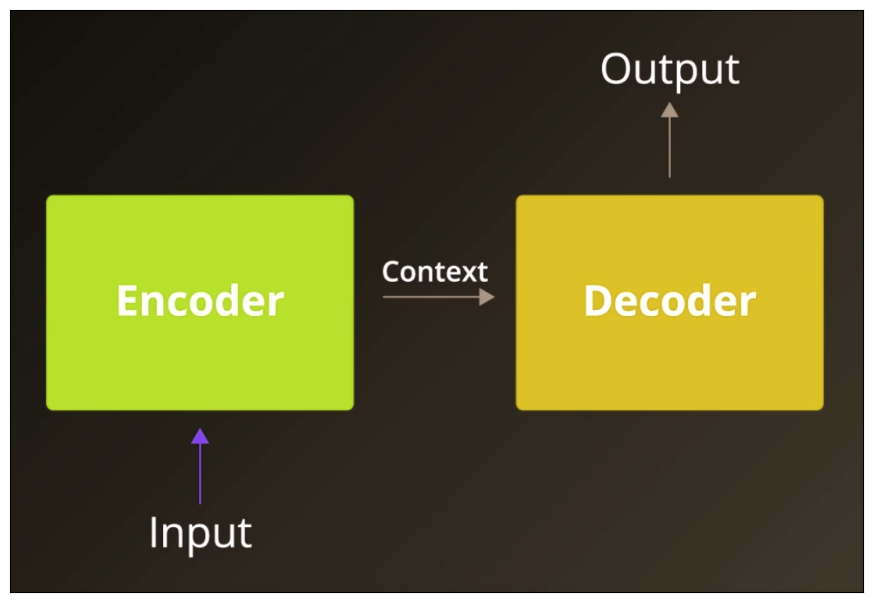

In [3]:
import cv2 as op
from matplotlib import pyplot as plt
img = op.imread("images/encoder-decoder-context.png")
plt.figure(figsize=(11,12))
plt.imshow(img)
plt.xticks([])
plt.yticks([])


([], [])

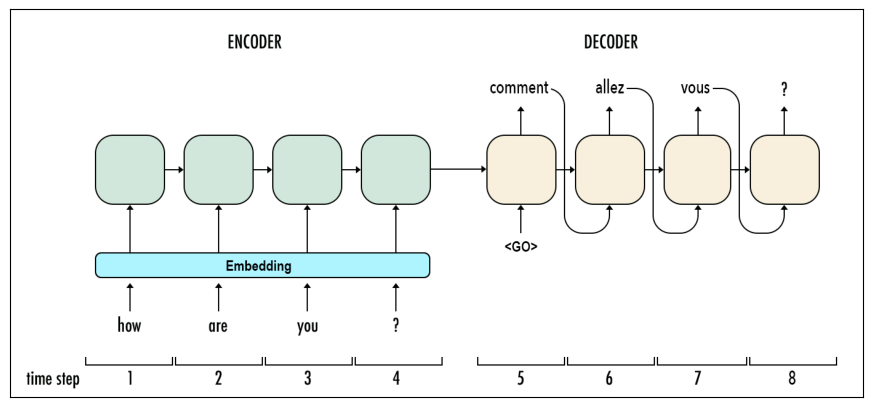

In [4]:
img = op.imread("images/encoder-decoder-translation.png")
plt.figure(figsize=(11,12))
plt.imshow(img)
plt.xticks([])
plt.yticks([])

([], [])

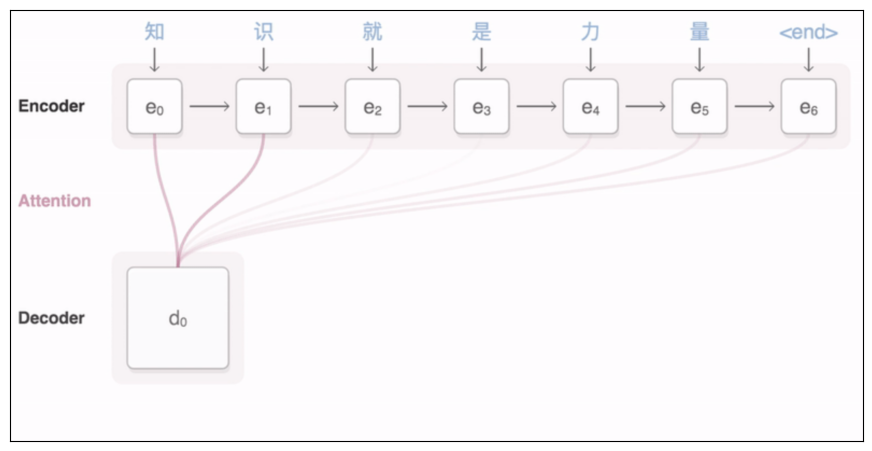

In [5]:
img = op.imread("images/attention.png")
plt.figure(figsize=(11,12))
plt.imshow(img)
plt.xticks([])
plt.yticks([])